In [ ]:
import os
import shutil
import random

def create_directories(base_dir, classes, splits):
    """
    Create the necessary directories for train, test, and validation splits.
    """
    for class_name in classes:
        for split in splits:
            # Create base class directories
            split_path = os.path.join(base_dir, split, class_name)
            os.makedirs(split_path, exist_ok=True)

def organize_dataset(input_dir, target_dir, num_train=200, num_test=100):
    """
    Organize dataset by creating train, test, and validation splits.
    """
    classes = ['cats', 'dogs', 'panda']
    splits = ['train', 'test', 'validation']

    # Create the necessary directories
    create_directories(target_dir, classes, splits)

    for category in classes:
        # Get all image files in the category
        category_input = os.path.join(input_dir, category)
        image_files = os.listdir(category_input)

        # Shuffle the images for random splitting
        random.shuffle(image_files)

        # Split images into train, test, and validation
        train_files = image_files[:num_train]
        test_files = image_files[num_train:num_train + num_test]
        validation_files = image_files[num_train + num_test:]

        # Copy files to corresponding directories
        for img_name in train_files:
            src = os.path.join(category_input, img_name)
            dst = os.path.join(target_dir, 'train', category, img_name)
            shutil.copy(src, dst)

        for img_name in test_files:
            src = os.path.join(category_input, img_name)
            dst = os.path.join(target_dir, 'test', category, img_name)
            shutil.copy(src, dst)

        for img_name in validation_files:
            src = os.path.join(category_input, img_name)
            dst = os.path.join(target_dir, 'validation', category, img_name)
            shutil.copy(src, dst)

# Example usage
input_dir = '/content/drive/MyDrive/animals'  # Path where original images are stored
target_dir = '/content/dataset/dataset/organized_splits'  # Path where the organized dataset will be stored

organize_dataset(input_dir, target_dir)


In [ ]:
import os
import cv2
import shutil

def preprocess_and_save(input_dir, output_dir, method='threshold'):
    """
    Preprocess images using either 'threshold' or 'edge' method and save them.
    """
    for category in ['cats', 'dogs', 'panda']:
        for split in ['train', 'test', 'validation']:
            category_input = os.path.join(input_dir, split, category)
            category_output = os.path.join(output_dir, method, split, category)
            os.makedirs(category_output, exist_ok=True)

            for img_name in os.listdir(category_input):
                img_path = os.path.join(category_input, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Apply preprocessing (threshold or edge detection)
                if method == 'threshold':
                    _, processed_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
                elif method == 'edge':
                    processed_img = cv2.Canny(img, 100, 200)

                # Save the processed image
                processed_img_path = os.path.join(category_output, img_name)
                cv2.imwrite(processed_img_path, processed_img)

# Define paths
input_dir = '/content/dataset/dataset/organized_splits'  # Path to the organized dataset
output_dir = '/content/dataset/dataset/processed'  # Path where processed images will be saved

# Apply preprocessing for threshold and edge detection
preprocess_and_save(input_dir, output_dir, method='threshold')  # Thresholded images
preprocess_and_save(input_dir, output_dir, method='edge')  # Edge-detected images


In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers
import tensorflow as tf


In [ ]:

# Function to load images and their labels from a directory
def load_data_from_directory(directory):
    images = []
    labels = []

    label_map = {'cats': 0, 'dogs': 1, 'panda': 2}  # Map labels to integers

    for category in ['cats', 'dogs', 'panda']:
        category_path = os.path.join(directory, category)

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Read the image and resize it
            img = cv2.imread(img_path)
            img = cv2.resize(img, (200, 200))  # Resize to (200, 200) as per your model input
            images.append(img)
            labels.append(label_map[category])

    return np.array(images), np.array(labels)

In [ ]:
# Define paths for thresholded and edge-detected data
train_threshold_path = '/content/dataset/dataset/processed/threshold/train'
test_threshold_path = '/content/dataset/dataset/processed/threshold/test'
val_threshold_path = '/content/dataset/dataset/processed/threshold/validation'

train_edge_path = '/content/dataset/dataset/processed/edge/train'
test_edge_path = '/content/dataset/dataset/processed/edge/test'
val_edge_path = '/content/dataset/dataset/processed/edge/validation'

# Load the data
X_train_thresh, y_train_thresh = load_data_from_directory(train_threshold_path)
X_test_thresh, y_test_thresh = load_data_from_directory(test_threshold_path)
X_val_thresh, y_val_thresh = load_data_from_directory(val_threshold_path)

X_train_edge, y_train_edge = load_data_from_directory(train_edge_path)
X_test_edge, y_test_edge = load_data_from_directory(test_edge_path)
X_val_edge, y_val_edge = load_data_from_directory(val_edge_path)

# Normalize the data
X_train_thresh = X_train_thresh / 255.0
X_test_thresh = X_test_thresh / 255.0
X_val_thresh = X_val_thresh / 255.0

X_train_edge = X_train_edge / 255.0
X_test_edge = X_test_edge / 255.0
X_val_edge = X_val_edge / 255.0

In [ ]:
# Define MobileNet-based model function
def create_mobilenet_model(input_shape=(200, 200, 3)):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')  # 3 output classes (cats, dogs, pandas)
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Data Augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift horizontally
    height_shift_range=0.2,  # Randomly shift vertically
    shear_range=0.2,  # Apply random shearing
    zoom_range=0.2,  # Apply random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in pixels that appear due to transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)  # For validation, only rescale

In [ ]:
# Define paths for thresholded and edge-detected images
train_threshold_path = '/content/dataset/dataset/processed/threshold/train'
test_threshold_path = '/content/dataset/dataset/processed/threshold/test'
val_threshold_path = '/content/dataset/dataset/processed/threshold/validation'

train_edge_path = '/content/dataset/dataset/processed/edge/train'
test_edge_path = '/content/dataset/dataset/processed/edge/test'
val_edge_path = '/content/dataset/dataset/processed/edge/validation'


In [ ]:
# Train and validation generators for thresholded images
train_generator_thresh = train_datagen.flow_from_directory(
    train_threshold_path,
    target_size=(200, 200),
    batch_size=16,
    class_mode='sparse'
)

val_generator_thresh = val_datagen.flow_from_directory(
    val_threshold_path,
    target_size=(200, 200),
    batch_size=16,
    class_mode='sparse'
)


Found 500 images belonging to 3 classes.
Found 400 images belonging to 3 classes.


In [ ]:
# Train and validation generators for edge-detected images
train_generator_edge = train_datagen.flow_from_directory(
    train_edge_path,
    target_size=(200, 200),
    batch_size=16,
    class_mode='sparse'
)

val_generator_edge = val_datagen.flow_from_directory(
    val_edge_path,
    target_size=(200, 200),
    batch_size=16,
    class_mode='sparse'
)



Found 500 images belonging to 3 classes.
Found 400 images belonging to 3 classes.


In [ ]:
# Train the model with thresholded images
mobilenet_model_thresh = create_mobilenet_model()

mobilenet_model_thresh.fit(
    train_generator_thresh,
    epochs=20,
    validation_data=val_generator_thresh
)


<ipython-input-7-8324c864cf41>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.4001 - loss: 3.6173 - val_accuracy: 0.9125 - val_loss: 2.2039
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.6626 - loss: 2.4779 - val_accuracy: 0.5475 - val_loss: 2.4455
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.6788 - loss: 2.1122 - val_accuracy: 0.8975 - val_loss: 1.5891
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.7096 - loss: 1.8417 - val_accuracy: 0.8825 - val_loss: 1.4261
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.7152 - loss: 1.7261 - val_accuracy: 0.9325 - val_loss: 1.1989
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7820 - loss: 1.4749 - val_accuracy: 0.9225 - val_loss: 1.1114
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.7742 - loss: 1.3569 - val_accuracy: 0.9025 - val_loss: 1.0572
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.7813 - loss: 1.2915 - val_accuracy: 0.8625 - v

In [ ]:
# Train the model with edge-detected images
mobilenet_model_edge = create_mobilenet_model()

mobilenet_model_edge.fit(
    train_generator_edge,
    epochs=20,
    validation_data=val_generator_edge
)

<ipython-input-7-8324c864cf41>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.4245 - loss: 3.5351 - val_accuracy: 0.8700 - val_loss: 2.2889
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.5503 - loss: 2.4031 - val_accuracy: 0.6225 - val_loss: 2.1795
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5741 - loss: 2.0327 - val_accuracy: 0.8300 - val_loss: 1.7045
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.5967 - loss: 1.8160 - val_accuracy: 0.6400 - val_loss: 1.6229
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.6363 - loss: 1.5726 - val_accuracy: 0.5550 - val_loss: 1.5459
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.6397 - loss: 1.4745 - val_accuracy: 0.8800 - val_loss: 1.1109
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.6875 - loss: 1.3722 - val_accuracy: 0.7000 - val_loss: 1.2925
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.6368 - loss: 1.3370 - val_accuracy: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Evaluate threshold model on test set
test_generator_thresh = val_datagen.flow_from_directory(
    test_threshold_path,
    target_size=(200, 200),
    batch_size=16,
    class_mode='sparse',
    shuffle=False  # Ensure predictions match the ground truth
)

test_loss_thresh, test_acc_thresh = mobilenet_model_thresh.evaluate(test_generator_thresh)
print(f'Threshold Model - Test Accuracy: {test_acc_thresh}, Test Loss: {test_loss_thresh}')


# Calculate classification report for threshold model
y_true_thresh = test_generator_thresh.classes
y_pred_thresh = mobilenet_model_thresh.predict(test_generator_thresh, verbose=1)
y_pred_thresh = np.argmax(y_pred_thresh, axis=1)
print("\nThreshold Model Classification Report:")
print(classification_report(y_true_thresh, y_pred_thresh))




Found 188 images belonging to 3 classes.
 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8717 - loss: 0.6373

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.8710 - loss: 0.6407
Threshold Model - Test Accuracy: 0.8776595592498779, Test Loss: 0.6296529769897461
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step

Threshold Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.85      0.90      0.87        88
           2       0.95      0.86      0.90       100

    accuracy                           0.88       188
   macro avg       0.60      0.59      0.59       188
weighted avg       0.90      0.88      0.89       188



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate edge model on test set
test_generator_edge = val_datagen.flow_from_directory(
    test_edge_path,
    target_size=(200, 200),
    batch_size=16,
    class_mode='sparse',
    shuffle=False  # Ensure predictions match the ground truth
)

test_loss_edge, test_acc_edge = mobilenet_model_edge.evaluate(test_generator_edge)
print(f'Edge Model - Test Accuracy: {test_acc_edge}, Test Loss: {test_loss_edge}')

# Calculate classification report for edge model
y_true_edge = test_generator_edge.classes
y_pred_edge = mobilenet_model_edge.predict(test_generator_edge, verbose=1)
y_pred_edge = np.argmax(y_pred_edge, axis=1)
print("\nEdge Model Classification Report:")
print(classification_report(y_true_edge, y_pred_edge))


Found 188 images belonging to 3 classes.
 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8368 - loss: 0.6452

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.8132 - loss: 0.7280
Edge Model - Test Accuracy: 0.7446808218955994, Test Loss: 0.8560277223587036
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step

Edge Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.90      0.77        88
           2       0.92      0.61      0.73       100

    accuracy                           0.74       188
   macro avg       0.53      0.50      0.50       188
weighted avg       0.80      0.74      0.75       188



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


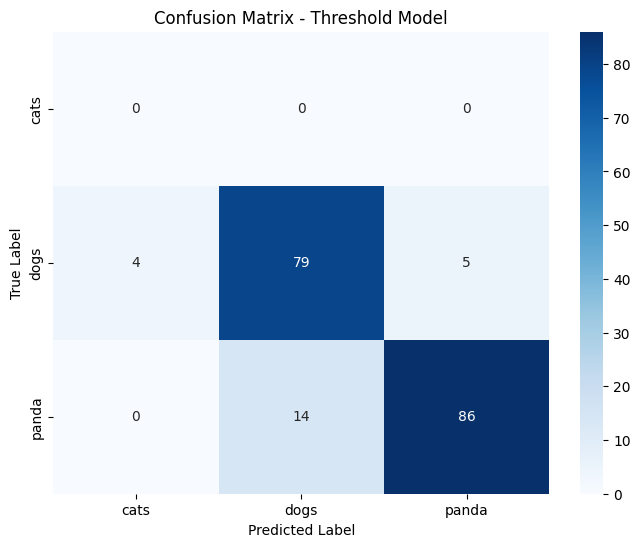

In [ ]:
# Get true labels and predictions for confusion matrix
y_true = test_generator_thresh.classes  # True labels
# Replace 'model' with your trained threshold model 'mobilenet_model_thresh'
y_pred = mobilenet_model_thresh.predict(test_generator_thresh)  # Predictions from the model
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
# Assuming you have imported seaborn as sns
import seaborn as sns # Import seaborn if you haven't already

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator_thresh.class_indices.keys(), yticklabels=test_generator_thresh.class_indices.keys())
plt.title("Confusion Matrix - Threshold Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


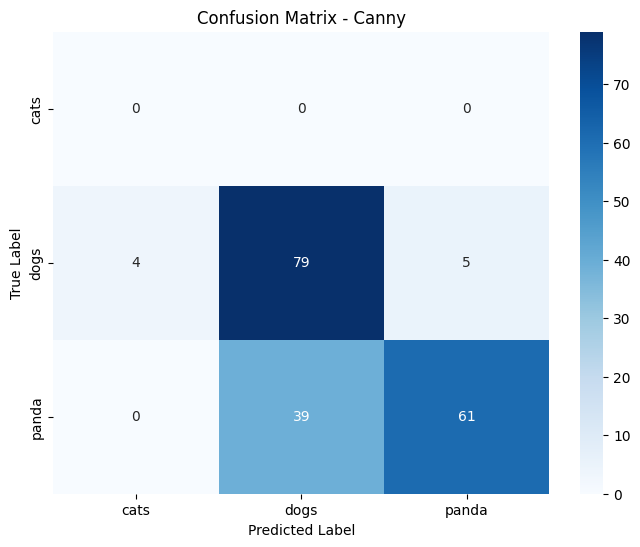

In [ ]:
# Get true labels and predictions for confusion matrix
y_true = test_generator_edge.classes  # True labels
y_pred = mobilenet_model_edge.predict(test_generator_edge)  # Predictions from the model
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator_thresh.class_indices.keys(), yticklabels=test_generator_thresh.class_indices.keys())
plt.title("Confusion Matrix - Canny")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Save the models
mobilenet_model_thresh.save('/content/mobilenet_model_thresh.h5')
mobilenet_model_edge.save('/content/mobilenet_model_edge.h5')


In [ ]:
# Function to preprocess the image (resize and normalize)
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in color (since model is trained on color images)
    img_resized = cv2.resize(img, (200, 200))  # Resize to match input size of the model
    img_normalized = img_resized / 255.0  # Normalize the image to [0, 1]
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    return img_expanded

# Function to predict the class of a new image
def predict_class(model, img_path):
    img = preprocess_image(img_path)  # Preprocess the image
    prediction = model.predict(img)  # Make the prediction
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the index of the predicted class

    # Map the predicted class index to the corresponding label
    labels = ['cats', 'dogs', 'pandas']
    predicted_label = labels[predicted_class]
    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class (Threshold model): cats


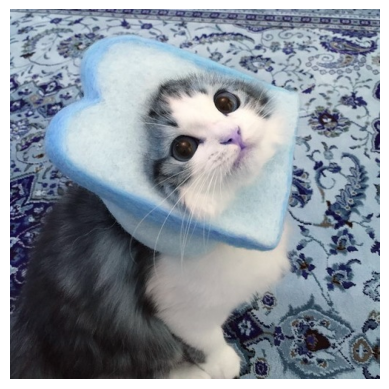

In [ ]:
img_path = '/content/cat.jpg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class (Threshold model): pandas


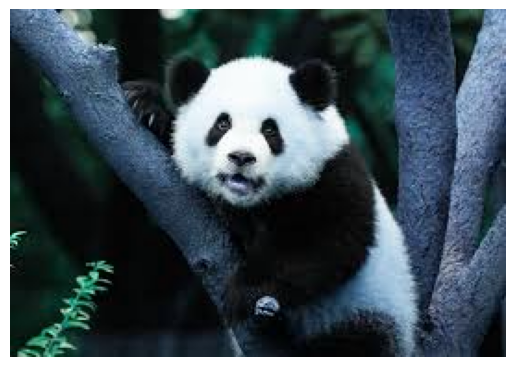

In [ ]:
img_path = '/content/pop.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class (Threshold model): cats


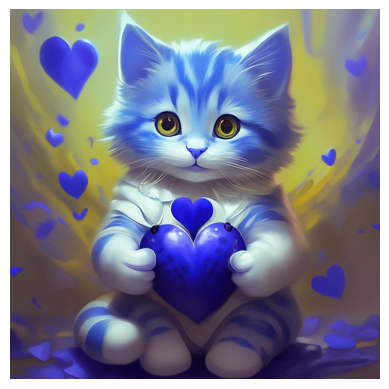

In [ ]:
img_path = '/content/cat.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class (Threshold model): dogs


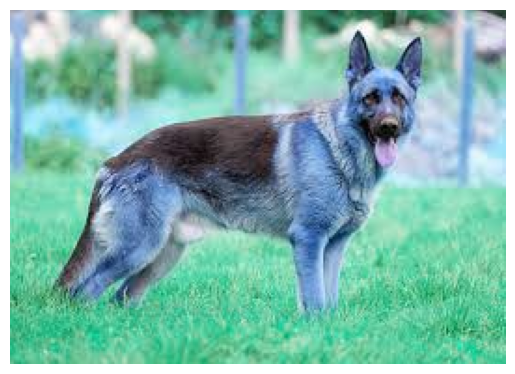

In [ ]:
img_path = '/content/001.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class (Threshold model): pandas


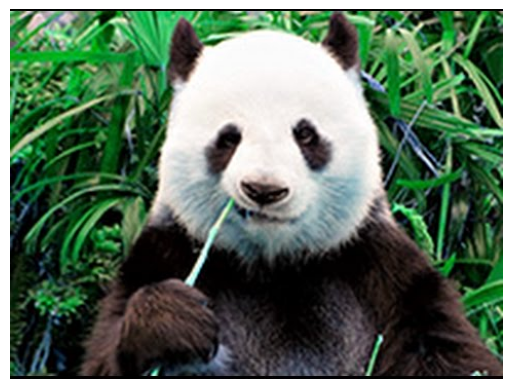

In [ ]:
img_path = '/content/panda.jpg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class (Threshold model): cats


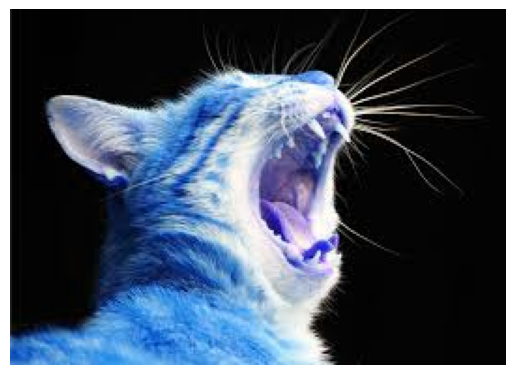

In [ ]:
img_path = '/content/catu.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class (Threshold model): pandas


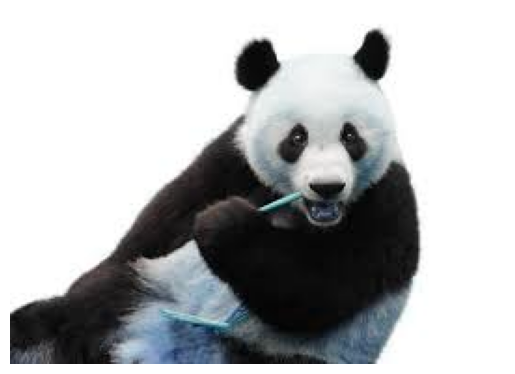

In [ ]:
img_path = '/content/pand1.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_thresh = predict_class(mobilenet_model_thresh, img_path)
print(f"Predicted class (Threshold model): {predicted_class_thresh}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class (Threshold model): dogs


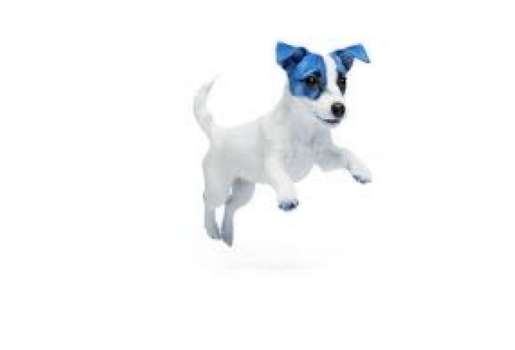

In [ ]:
img_path = '/content/dod1.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_edge = predict_class(mobilenet_model_edge, img_path)
print(f"Predicted class (edge_model): {predicted_class_edge}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

In [ ]:
/content/mobilenet_model_edge.h5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class (Threshold model): cats


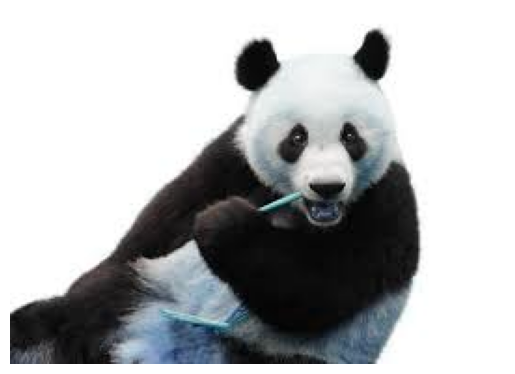

In [ ]:
img_path = '/content/pand1.jpeg'

# Predict using the threshold model (replace with your model)
predicted_class_edge = predict_class(mobilenet_model_edge, img_path)
print(f"Predicted class ( model): {predicted_class_edge}")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()